# Titanic kaggle competition with SVM

In [78]:
#import all the needed package
import numpy as np
import scipy as sp
import re
import pandas as pd
import sklearn
from sklearn.cross_validation import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import matplotlib 
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.svm import SVC


Let's load and examine the titanic data with pandas first.

In [79]:
data = pd.read_csv('data/train.csv')
#print data.head()

In [80]:
# our target is the survived column
y= data['Survived']

In [81]:
print data.shape

(891, 12)


So we have 891 training examples with 10 information columns given. Of course it is not straight forward to use all of them at this point. 
In this example, we will just explore two simple SVM models that only use two features. 
Our choice of models are:
- gender, class
- gender, feature

## Gender-Class model

Recall how we generated features from catagories last session. We use the same method to generate an additional feature called Sex_male. 

In [82]:
#add in Sex_male features
data['Sex_male']=data.Sex.map({'female':0,'male':1})
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


In [83]:
#get the features we indented to use 
feature_cols=['Pclass','Sex_male']
X=data[feature_cols]
X.head()

,Pclass,Sex_male
0,3,1
1,1,0
2,3,0
3,1,0
4,3,1


In [84]:
#use the default SVC: SVM rbf model, degree 3
model=SVC()
scores=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print scores 
print np.mean(scores),np.std(scores)

[ 0.74444444  0.74444444  0.75280899  0.84269663  0.79775281  0.7752809
  0.76404494  0.74157303  0.80898876  0.76136364]
0.773339859267 0.0316406841133


Here is how we examine how the selection works. 

In [85]:
xmin,xmax=X['Pclass'].min()-0.5,X['Pclass'].max()+0.5
ymin,ymax=X['Sex_male'].min()-0.5,X['Sex_male'].max()+0.5
print xmin,xmax,ymin,ymax
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))

0.5 3.5 -0.5 1.5


In [86]:
model.fit(X,y)
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

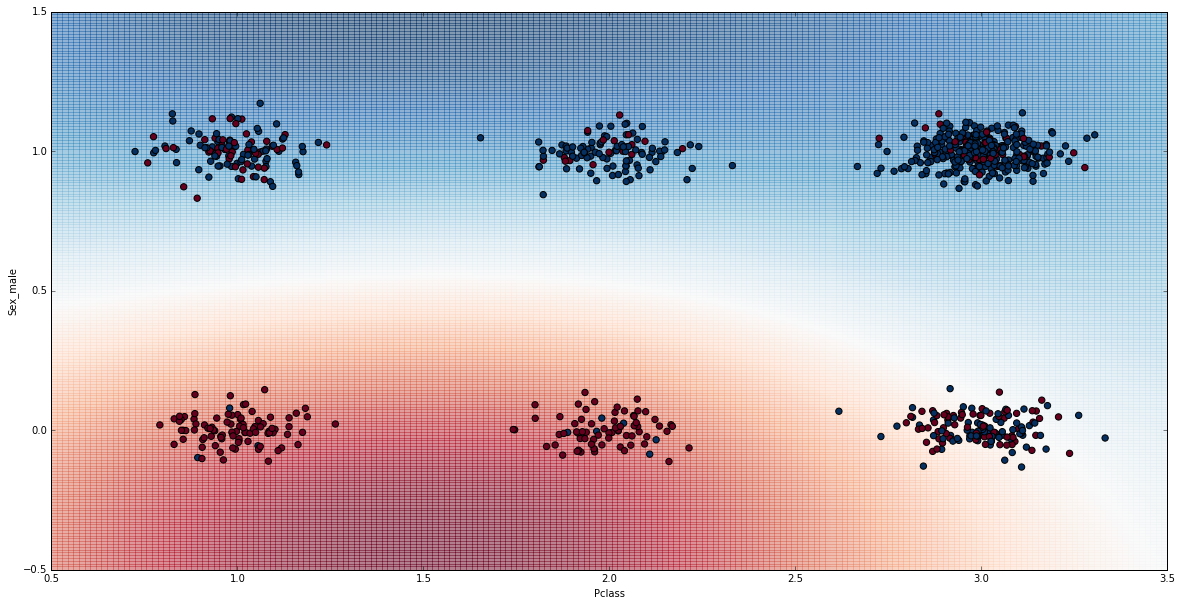

In [87]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
ax.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu,alpha=0.5)
ax.scatter(X['Pclass']+np.random.randn(len(X['Pclass']))*0.1, X['Sex_male']+np.random.randn(len(X['Pclass']))*0.05, c=y,s=40, cmap=plt.cm.RdBu_r)
ax.set_xlabel("Pclass")
ax.set_ylabel("Sex_male")
ax.set_xlim([0.5,3.5])
ax.set_ylim([-0.5,1.5])
plt.show()

## Gender-Age model

We will introduce a few concepts while including the Age feature. 

### missing values
1. identify missing values

In [88]:
#use the isnull function to check if there is any missing value in the Age column. 
pd.isnull(data['Age']).any()

True

How many missing values are there? 

In [89]:
print len(data['Age'][pd.isnull(data['Age'])])

177


SVM does not allow features with missing values, what do we do? 

One idea would be to fill in them with a number we think is reasonable. 

Let's try to use the average age first. 

In [90]:
data['Age'][pd.isnull(data['Age'])]=data['Age'].mean()

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


### can you think of better ways to do this?

In [91]:
#generate our new feature
feature_cols=['Age','Sex_male']
X=data[feature_cols]
X.head()

,Age,Sex_male
0,22.0,1
1,38.0,0
2,26.0,0
3,35.0,0
4,35.0,1


In [92]:
#use the default SVM rbf model
scores=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print scores
print np.mean(scores),np.std(scores)

[ 0.76666667  0.81111111  0.7752809   0.86516854  0.79775281  0.75280899
  0.7752809   0.71910112  0.80898876  0.75      ]
0.782215980025 0.0385983525122


### feature rescaling

In [98]:
X['Age']=(X['Age']-X['Age'].median())/X['Age'].std()
#X = StandardScaler().fit_transform(X)

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [97]:
scores=cross_val_score(model,X,y,cv=10,scoring='accuracy')
print scores
print np.mean(scores),np.std(scores)

[ 0.77777778  0.8         0.7752809   0.87640449  0.79775281  0.78651685
  0.76404494  0.74157303  0.84269663  0.78409091]
0.794613834979 0.03690775395


Let's examine the selection function of the model. 

In [95]:
xmin,xmax=X['Age'].min()-0.5,X['Age'].max()+0.5
ymin,ymax=X['Sex_male'].min()-0.5,X['Sex_male'].max()+0.5
print xmin,xmax,ymin,ymax
xx, yy = np.meshgrid(np.linspace(xmin, xmax, 200), np.linspace(ymin, ymax, 200))

/Users/silburt/anaconda2/envs/ml/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
model.fit(X,y)
Z = model.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

In [ ]:
fig=plt.figure(figsize=(20,10))
ax=fig.add_subplot(111)
ax.pcolormesh(xx, yy, -Z, cmap=plt.cm.RdBu,alpha=0.5)
ax.scatter(X['Age'], X['Sex_male']+np.random.randn(len(X['Age']))*0.05, c=y,s=40, cmap=plt.cm.RdBu_r)
ax.set_xlabel("Normalized Age")
ax.set_ylabel("Sex_male")
ax.set_ylim([-0.5,1.5])
ax.set_xlim([-3,4.5])
plt.show()

## Create a submission file with the Gender-Age model

First we want to read in the test data set and add in the gender features as what we did with the training data set. 

In [ ]:
test_data = pd.read_csv('data/test.csv')
#print test_data.head()
#add in Sex_male features
test_data['Sex_male']=test_data.Sex.map({'female':0,'male':1})

We notice again that some of the age value is missing in the test data, and want to fill in **the same way** as what we did with the training data. 

In [ ]:
#use the isnull function to check if there is any missing value in the Age column. 
pd.isnull(test_data['Age']).any()

In [ ]:
print len(test_data['Age'][pd.isnull(test_data['Age'])])

In [ ]:
test_data['Age'][pd.isnull(test_data['Age'])]=data['Age'].mean()

Note here we give the missing values the mean age of the training data. 

What's the pros and cons of doing this? 

We want to get the features from the test data, and scale our age feature **the same way** as what we did in the training data.  

In [ ]:
#generate our new feature
X_test=test_data[feature_cols]
X_test['Age']=(X_test['Age']-data['Age'].median())/data['Age'].std()

We use the model above to predict the survive of our test data. 

**The model is fitted with the entire training data.**

In [ ]:
y_pred=model.predict(X_test)
X_test.head()

### create a file that can be submit to kaggle
We read in the example submission file provided by kaggle, and then replace the "Survived" column with our own prediction.

We use the to_csv method of panda dataframe, now we can check with kaggle on how well we are doing.  

In [ ]:
samplesubmit = pd.read_csv("data/titanic_submit_example.csv")
#samplesubmit.head()

In [ ]:
samplesubmit["Survived"]=y_pred
#samplesubmit.to_csv
samplesubmit.to_csv("data/titanic_submit_gender_age.csv",index=False)


In [ ]:
samplesubmit.head()